<a href="https://colab.research.google.com/github/mariang168/SU_MSADS/blob/main/Zip94804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## SAMPLE TIME SERIES USING RETAIL DATA
## BASED ON MILLER (2015) and BROWNLEE (2016)

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
import seaborn as sns
import numpy as np

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('tab10', 8)))
dims = (11.7, 8.27)
%matplotlib inline

## Setting random seed
np.random.seed(1000)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Zip97212 = pd.read_csv("Zip97212.csv").fillna(0)
Zip94804 = pd.read_csv("https://raw.githubusercontent.com/mariang168/SU_MSADS/main/IST718/Zip94804.csv").fillna(0)
#Zip98340 = pd.read_csv("Zip98340.csv").fillna(0)

In [3]:
#Zip94804
C_t = Zip94804.transpose()
C_t = pd.DataFrame(C_t)
C = C_t.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'])
#O = O.sort_index()
C.index.name = "Date"
C.index = pd.to_datetime(C.index)
C['Price']= C.mean(axis=1)
C

,0,Price
Date,,
1996-01-31,183992.0343,183992.0343
1996-02-29,178934.9969,178934.9969
1996-03-31,177687.123,177687.1230
1996-04-30,175233.9138,175233.9138
1996-05-31,176664.9931,176664.9931
...,...,...
2022-02-28,817895.7591,817895.7591
2022-03-31,865358.151,865358.1510
2022-04-30,869453.853,869453.8530


In [4]:
# EXPLORE - IS OUR TIME SERIES STATIONARY OR NOT?

result = adfuller(C['Price'], autolag='AIC')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.153974
p-value: 0.943790
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


ADF Statistic: -1.756806
p-value: 0.402107
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


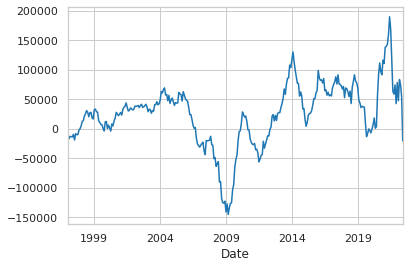

In [5]:
# SCRUB - OUR TIME SERIES IS NOT STATIONARY - WE NEED TO TAKE THE DIFFERENCE
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

#X = O['Price']
X = C['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = C.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()

In [6]:
# SCRUB - SOME CODE TO INVERT DIFFERENCE VALUE

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

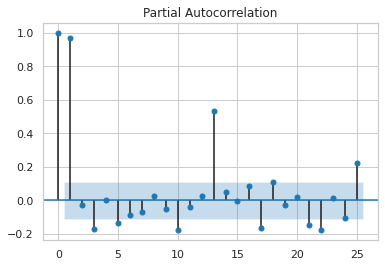

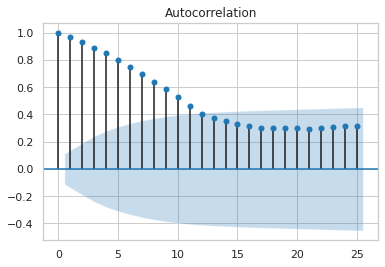

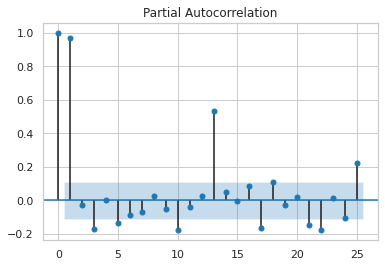

In [7]:
# USING STATIONARY TIME SERIES LOOK AT ACF

series = stationary

plot_acf(series)
plot_pacf(series)

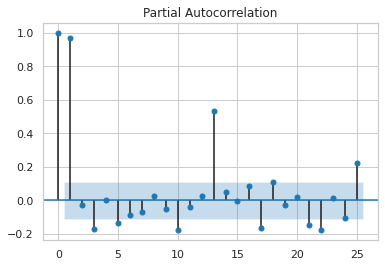

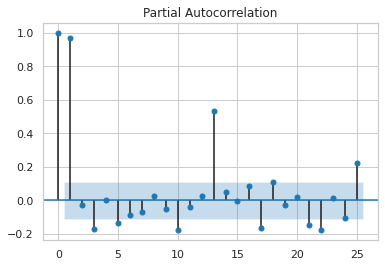

In [8]:
# USING STATIONARY TIME SERIES LOOK FOR PACF

plot_pacf(series)

In [9]:
# BUILD THE MODEL - USING ORIGINAL SERIES1 DATA

# prepare data
#X = O['Price']
X = C['Price']
X = X.astype('float32')
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=411066.479, Expected=418459
>Predicted=421772.748, Expected=424800
>Predicted=421470.408, Expected=453008
>Predicted=462030.225, Expected=446740
>Predicted=462818.815, Expected=449656
>Predicted=452016.356, Expected=456307
>Predicted=461767.484, Expected=457345
>Predicted=459011.976, Expected=466495
>Predicted=467916.872, Expected=448419
>Predicted=456797.495, Expected=456670
>Predicted=466222.810, Expected=462503
>Predicted=465430.991, Expected=470300
>Predicted=478057.829, Expected=474241
>Predicted=481764.758, Expected=482065
>Predicted=508739.757, Expected=508504
>Predicted=502586.043, Expected=515724
>Predicted=518427.503, Expected=524699
>Predicted=534989.186, Expected=535645
>Predicted=538356.042, Expected=545237
>Predicted=555714.491, Expected=542186
>Predicted=526103.758, Expected=539795
>Predicted=544990.474, Expected=532432
>Predicted=542482.520, Expected=537468
>Predicted=541071.536, Expected=542849
>Predicted=546561.582, Expected=541539
>Predicted=548683.089, Ex

In [10]:
# CODE RUNS LONG FOR EVALUATION - approximately 34 mins on COLAB
import warnings
import numpy
  
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# LOAD DATA

series = C['Price']
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=38874.611
ARIMA(0, 1, 1) RMSE=16415.879
ARIMA(0, 1, 2) RMSE=16336.212
ARIMA(0, 1, 3) RMSE=16470.896
ARIMA(0, 2, 1) RMSE=17132.876
ARIMA(1, 0, 0) RMSE=16228.930
ARIMA(1, 1, 0) RMSE=16438.558
ARIMA(1, 1, 1) RMSE=16441.989
ARIMA(1, 1, 2) RMSE=16554.727
ARIMA(1, 1, 3) RMSE=16594.897
ARIMA(1, 2, 0) RMSE=17997.628
ARIMA(1, 2, 1) RMSE=16978.630
ARIMA(1, 2, 2) RMSE=17187.336
ARIMA(1, 2, 3) RMSE=16857.719
ARIMA(2, 0, 0) RMSE=16305.916
ARIMA(2, 1, 0) RMSE=16273.618
ARIMA(2, 1, 1) RMSE=16488.168
ARIMA(2, 1, 2) RMSE=16608.922
ARIMA(2, 1, 3) RMSE=16831.073
ARIMA(2, 2, 0) RMSE=18069.404
ARIMA(2, 2, 1) RMSE=16740.556
ARIMA(2, 2, 2) RMSE=17075.153
ARIMA(2, 2, 3) RMSE=16763.315
ARIMA(3, 0, 0) RMSE=16084.358
ARIMA(3, 1, 0) RMSE=16469.177
ARIMA(3, 1, 1) RMSE=16545.965
ARIMA(3, 1, 2) RMSE=16942.081
ARIMA(3, 2, 0) RMSE=17743.005
ARIMA(3, 2, 1) RMSE=16983.576
Best ARIMA(3, 0, 0) RMSE=16084.358


                  0
count    159.000000
mean     305.778463
std    15648.425947
min   -61124.741347
25%    -7184.721092
50%     1566.770576
75%     9928.674609
max    47915.505136
RMSE: 15602.136


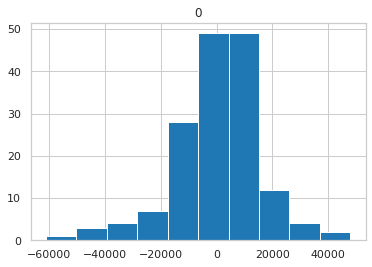

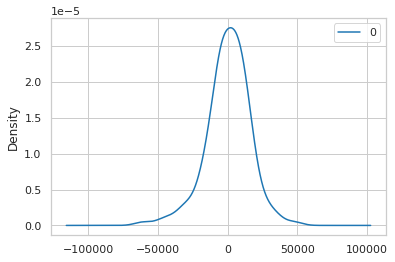

In [130]:
#Zip97212 ARIMA()
#@title
# SIMILAR BLOCK OF CODE - THIS ONE SAVES RESIDUALS FOR PLOTTING

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = C['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(0,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

                  0
count    159.000000
mean     426.491550
std    15648.425947
min   -61004.028260
25%    -7064.008005
50%     1687.483663
75%    10049.387696
max    48036.218223
RMSE: 15604.969


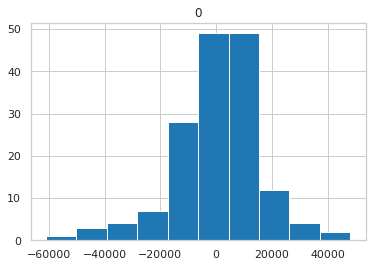

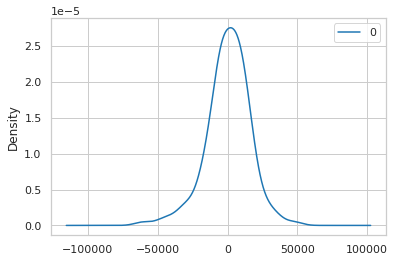

In [131]:
# MODEL - INTERPRET 
# RECREATE ANALYSIS WITH MEAN RESIDUAL ADDED TO EACH PREDICTION
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = C['Price']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -120.713087
for i in range(len(test)):
	# difference data
	weeks_in_year = 52
	diff = difference(history, weeks_in_year)
	# predict
	model = ARIMA(diff, order=(0,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, weeks_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# plot
residuals.hist(ax=plt.gca())
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()

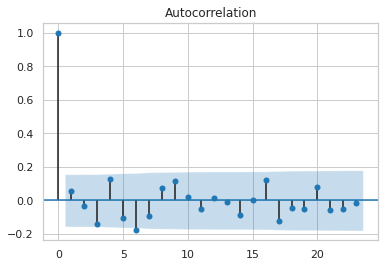

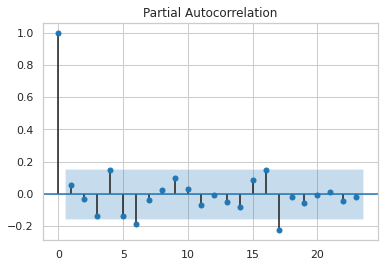

In [65]:
# INTERPRET -LOOK AT ACF AND PACF FOR RESIDUALS
# Ideally all residuals are not significant and mean==0
plot_acf(residuals, ax=plt.gca())
plt.show()

plot_pacf(residuals, ax=plt.gca())
plt.show()

In [132]:
# MODEL - CODE FROM BROWNLEE FOR SAVING MODEL
# NOTE:  This will save in your google drive UNLESS you specified a particular
# working directory

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = C['Price']
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, weeks_in_year)
# fit model
model = ARIMA(diff, order=(0,2,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual - CHANGED TO ZERO
bias = 0
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [84]:
# MODEL
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING ONE STEP AHEAD

def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = C['Price']
months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, weeks_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 817179.381


In [33]:
#Pull Zip97212, Zip94804, Zip98340 file
from google.colab import files
uploaded = files.upload()

Saving C.csv to C.csv


In [133]:
# INTERPRET - CREATE TRAIN-TEST DATA
# DATA IS WEEKLY FOR 2+ years
# KEEP ONE QUARTER - 13 weeks - AS THE TEST DATA
#series1 = pd.read_csv('C.csv', header=0,
#                     index_col="Date", parse_dates=["Date"])
series1 = C
split_point = len(series) - 6
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# STORES TO LOCAL DRIVE
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 312, Validation 6


>Predicted=1069264.117, Expected=812339
>Predicted=785863.385, Expected=817896
>Predicted=778202.026, Expected=865358
>Predicted=868024.275, Expected=869454
>Predicted=876238.971, Expected=851362
>Predicted=850949.175, Expected=815151
RMSE: 112941.831


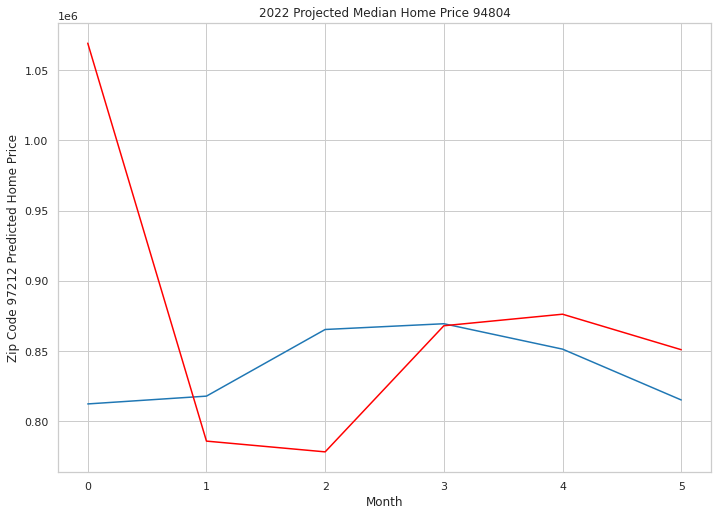

In [134]:
# MODEL & INTERPRET - 
# CODE FOR MAKING PREDICTION USING SAVED MODEL - LOOKING MANY STEPS AHEAD
# NEED VALIDATION FILE FROM ABOVE


def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = C['Price']
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12

#validation = Series.from_csv('validation.csv', header=0)
y = validation.values.astype('float32')

# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)

	# predict
	model = ARIMA(diff, order=(0,2,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)

# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
 
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

fig, ax = plt.subplots(figsize = dims)
plt.plot(y)
plt.plot(predictions, color='red')
plt.xlabel("Month")
plt.ylabel("Zip Code 97212 Predicted Home Price")
plt.title("2022 Projected Median Home Price 94804")
plt.show()

In [87]:
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  309
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -3395.099
Method:                       css-mle   S.D. of innovations          14173.916
Date:                Mon, 15 Aug 2022   AIC                           6796.198
Time:                        01:08:06   BIC                           6807.398
Sample:                             2   HQIC                          6800.676
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2050      8.996      0.023      0.982     -17.426      17.836
ma.L1.D2.y    -1.0000      0.009   -110.709      0.000      -1.018      -0.982
                                    Roots           